In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn.model_selection

import tpot

In [2]:
MAX_TIME = 5 # minutes
RANDOM_SEED = 1234

In [3]:
csv_files = [i for i in os.listdir() if i.endswith("csv")]
dataframes = [pd.read_csv(file, index_col="Unnamed: 0") for file in csv_files]

experiments = {}
for filename, dataframe in zip(csv_files, dataframes):
    
    dataframe = dataframe[dataframe["discovery_process (unitless)"] == "top-down"]
    
    if len(dataframe) > 0:
        experiments[filename] = dataframe
print("\n".join(experiments.keys()))

both_carbidesOnly.csv
both_chalcogensOnly.csv
both_conventionalSemiconductorsOnly.csv
both_extra_descriptors.csv
both_halidesOnly.csv
both_nitridesOnly.csv
both_oxidesOnly.csv
both_pBlockMetalsOnly.csv
both_pnictogensOnly.csv
both_sulfidesOnly.csv
both_UWBGOnly.csv
both_WBGOnly.csv


In [4]:
targets = ["bandgap (eV)", "exfoliation_energy_per_atom (eV/atom)"]
n_models = len(experiments.keys()) * len(targets)

print(f"Estimated time to evaluate all {n_models} scenarios, budgeting {MAX_TIME} minutes per model: {n_models * MAX_TIME} minutes")

Estimated time to evaluate all 24 scenarios, budgeting 5 minutes per model: 120 minutes


In [5]:
def experiment_generator():
    for name, df in experiments.items():
        for target in targets:
            yield name, df, target
experiment = experiment_generator()

def run_experiment(name, df, target):
    test_size = 0.1
    regression_irrelevant = [
        '2dm_id (unitless)',
        'formula',
        'discovery_process (unitless)',
        'potcars (unitless)',
        'is_hubbard (unitless)',
        'energy_per_atom (eV)',
        'decomposition_energy (eV/atom)',
        'is_bandgap_direct (unitless)',
        'is_metal (unitless)',
        'energy_vdw_per_atom (eV/atom)',
        'total_magnetization (Bohr Magneton)']
    
    # Ignore other target columns
    other_targets = [col for col in targets if col != target]
    df = df.drop(columns=other_targets + regression_irrelevant)
    
    # Train / Test Split
    data_train, data_test = sklearn.model_selection.train_test_split(df, test_size=test_size, random_state=RANDOM_SEED)
    train_x = data_train.drop(columns=target).to_numpy()
    train_y = data_train[target].to_numpy()
    
    test_x = data_test.drop(columns=target).to_numpy()
    test_y = data_test[target].to_numpy()
    
    # Train a model
    model = tpot.TPOTRegressor(
        generations=None,
        population_size=100,
        max_eval_time_mins=5/60,
        max_time_mins=MAX_TIME,
        cv=4,
        verbosity=2,
        scoring="r2",
        config_dict=tpot.config.regressor_config_dict,
        n_jobs=22,
        random_state=RANDOM_SEED
    )
    model.fit(features=train_x, target=train_y)
    
    train_y_pred = model.predict(train_x)
    test_y_pred = model.predict(test_x)
    
    print("Test-Set Error Metrics:")
    for name, metric in [
        ["MAE", sklearn.metrics.mean_absolute_error],
        ["MAPE", sklearn.metrics.mean_absolute_percentage_error],
        ["MSE", sklearn.metrics.mean_squared_error],
        ["R2", sklearn.metrics.r2_score],
        ["Max Error", sklearn.metrics.max_error]
    ]:
        print(f"{name}: {np.round(metric(y_true=test_y, y_pred=test_y_pred), 3)}")
    
    # Plot the results   
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    plt.rcParams["figure.figsize"] = (10,10)
    plt.rcParams["font.size"] = 16

    plt.scatter(x=train_y_pred, y=train_y, label="Train Set")
    plt.scatter(x=test_y_pred, y=test_y, label="Test Set")
    
    min_xy = min(min(train_y_pred), min(train_y))
    max_xy = max(max(train_y_pred), max(train_y))
    
    plt.plot([min_xy,max_xy], [min_xy,max_xy], label="Parity")
    plt.ylabel(f"{target} (Dataset)")
    plt.xlabel(f"{target} (Predicted)")
    plt.legend()
    plt.show()

In [6]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_carbidesOnly.csv
Rows: 3
Target: bandgap (eV)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]

Something went wrong, continuing down to the other experiments. Traceback:
A pipeline has not yet been optimized. Please call fit() first.


In [7]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_carbidesOnly.csv
Rows: 3
Target: exfoliation_energy_per_atom (eV/atom)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]

Something went wrong, continuing down to the other experiments. Traceback:
A pipeline has not yet been optimized. Please call fit() first.


Name: both_chalcogensOnly.csv
Rows: 173
Target: bandgap (eV)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7277972693886603

Generation 2 - Current best internal CV score: 0.7350411297835916

Generation 3 - Current best internal CV score: 0.7413937402519735

Generation 4 - Current best internal CV score: 0.7413937402519735

Generation 5 - Current best internal CV score: 0.7413937402519735

Generation 6 - Current best internal CV score: 0.7413937402519735

5.18 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=4, min_child_weight=9, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=1.0, verbosity=0)
Imputing missing values in feature set
Imputing missing values in feature set
Test-Set Error Metrics:
MAE: 0.352
MAPE: 1.898
MSE: 0.255
R2: 0.762
Max Error: 1.646


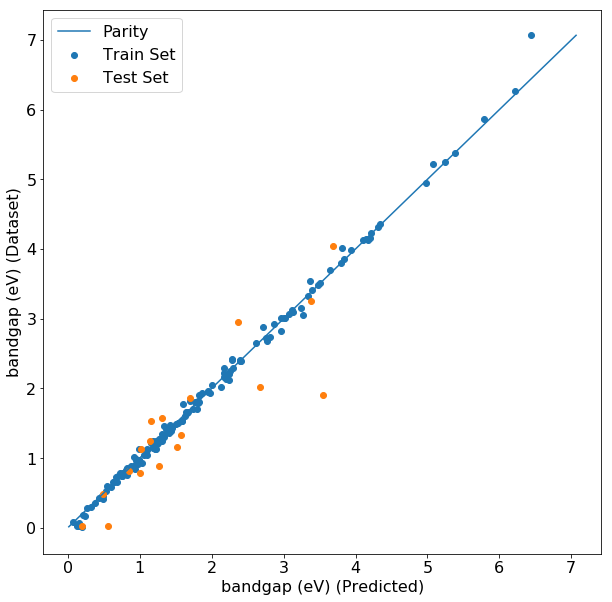

In [8]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_chalcogensOnly.csv
Rows: 173
Target: exfoliation_energy_per_atom (eV/atom)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.3856310391891985

Generation 2 - Current best internal CV score: 0.3856310391891985

Generation 3 - Current best internal CV score: 0.3856310391891985

Generation 4 - Current best internal CV score: 0.3856310391891985

Generation 5 - Current best internal CV score: 0.3856310391891985

Generation 6 - Current best internal CV score: 0.3856310391891985

Generation 7 - Current best internal CV score: 0.3856310391891985

5.14 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: XGBRegressor(input_matrix, learning_rate=0.5, max_depth=6, min_child_weight=20, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.6500000000000001, verbosity=0)
Imputing missing values in feature set
Imputing missing values in feature set
Test-Set Error Metrics:
MAE: 0.022
MAPE: 0.331
MSE: 0.001
R2: 0.303
Max Error: 0.054


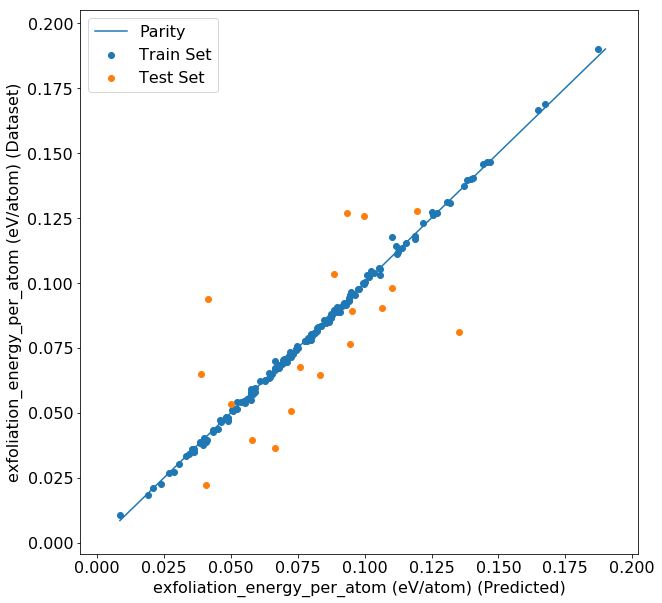

In [9]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_conventionalSemiconductorsOnly.csv
Rows: 171
Target: bandgap (eV)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.3754626450502416

Generation 2 - Current best internal CV score: 0.3905302578044729

Generation 3 - Current best internal CV score: 0.3905302578044729

Generation 4 - Current best internal CV score: 0.3905302578044729

Generation 5 - Current best internal CV score: 0.3943567478410807

5.34 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesRegressor(SGDRegressor(input_matrix, alpha=0.001, eta0=0.01, fit_intercept=False, l1_ratio=1.0, learning_rate=invscaling, loss=squared_loss, penalty=elasticnet, power_t=1.0), bootstrap=False, max_features=1.0, min_samples_leaf=2, min_samples_split=6, n_estimators=100)
Imputing missing values in feature set
Imputing missing values in feature set
Test-Set Error Metrics:
MAE: 0.353
MAPE: 0.497
MSE: 0.226
R2: 0.115
Max Error: 1.28


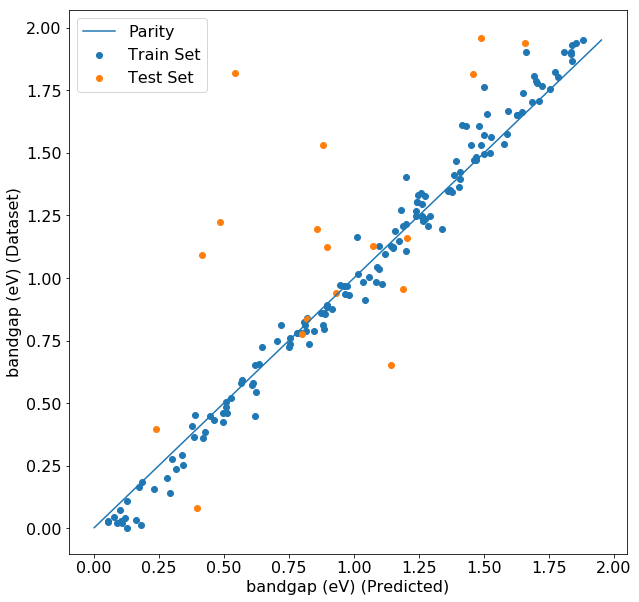

In [10]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_conventionalSemiconductorsOnly.csv
Rows: 171
Target: exfoliation_energy_per_atom (eV/atom)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.4612461038200282

Generation 2 - Current best internal CV score: 0.4612461038200282

Generation 3 - Current best internal CV score: 0.4612461038200282

Generation 4 - Current best internal CV score: 0.4612461038200282

Generation 5 - Current best internal CV score: 0.4612461038200282

5.05 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: XGBRegressor(MinMaxScaler(input_matrix), learning_rate=0.1, max_depth=5, min_child_weight=7, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.55, verbosity=0)
Imputing missing values in feature set
Imputing missing values in feature set
Test-Set Error Metrics:
MAE: 0.014
MAPE: 0.219
MSE: 0.0
R2: 0.648
Max Error: 0.043


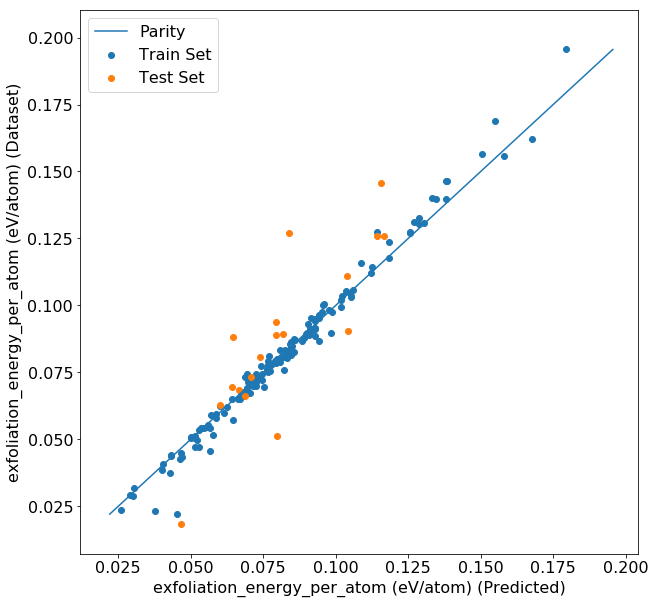

In [11]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_extra_descriptors.csv
Rows: 273
Target: bandgap (eV)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.6672378820960434

Generation 2 - Current best internal CV score: 0.6672378820960434

Generation 3 - Current best internal CV score: 0.6803381907182917

Generation 4 - Current best internal CV score: 0.6869186858244151

Generation 5 - Current best internal CV score: 0.6869186858244151

5.19 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: GradientBoostingRegressor(MaxAbsScaler(LassoLarsCV(input_matrix, normalize=True)), alpha=0.8, learning_rate=0.1, loss=ls, max_depth=5, max_features=0.35000000000000003, min_samples_leaf=2, min_samples_split=10, n_estimators=100, subsample=0.4)
Imputing missing values in feature set
Imputing missing values in feature set
Test-Set Error Metrics:
MAE: 0.382
MAPE: 1.395
MSE: 0.248
R2: 0.847
Max Error: 1.16


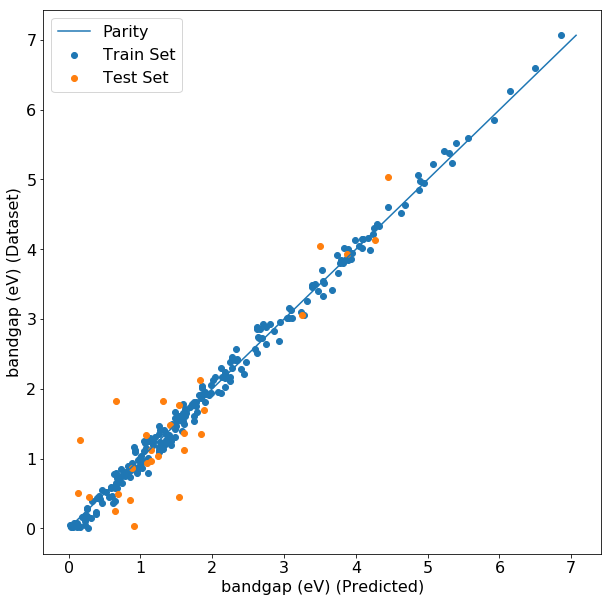

In [12]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_extra_descriptors.csv
Rows: 273
Target: exfoliation_energy_per_atom (eV/atom)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.45646893385573994

Generation 2 - Current best internal CV score: 0.45646893385573994

Generation 3 - Current best internal CV score: 0.46339352294987457

Generation 4 - Current best internal CV score: 0.4873921986181924

Generation 5 - Current best internal CV score: 0.4873921986181924

Generation 6 - Current best internal CV score: 0.49282683725347187

6.15 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: GradientBoostingRegressor(XGBRegressor(XGBRegressor(RobustScaler(input_matrix), learning_rate=0.01, max_depth=5, min_child_weight=6, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.15000000000000002, verbosity=0), learning_rate=0.001, max_depth=4, min_child_weight=19, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.35000000000000003, verbosity=0), alpha=0.8, learning_rate=0

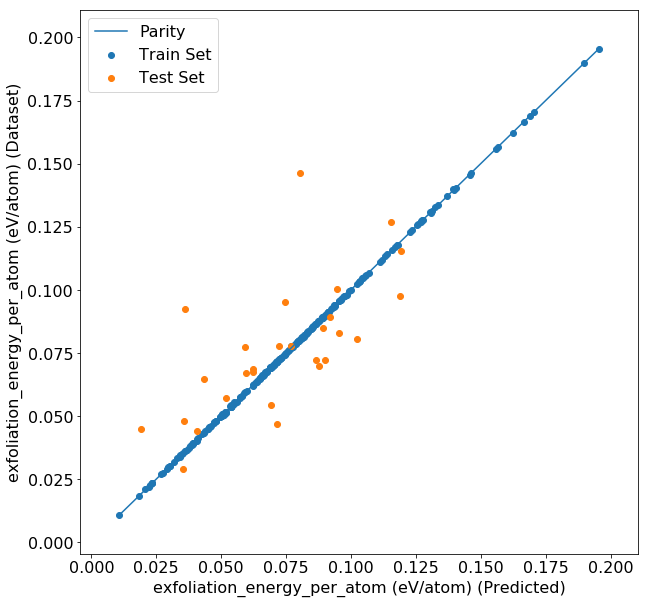

In [13]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_halidesOnly.csv
Rows: 119
Target: bandgap (eV)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.5933628559388124

Generation 2 - Current best internal CV score: 0.5933628559388124

Generation 3 - Current best internal CV score: 0.5933628559388124

Generation 4 - Current best internal CV score: 0.5956905989776613

Generation 5 - Current best internal CV score: 0.6105209541811413

Generation 6 - Current best internal CV score: 0.6105209541811413

6.23 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: GradientBoostingRegressor(RandomForestRegressor(input_matrix, bootstrap=True, max_features=0.6500000000000001, min_samples_leaf=8, min_samples_split=19, n_estimators=100), alpha=0.95, learning_rate=0.1, loss=ls, max_depth=10, max_features=0.6000000000000001, min_samples_leaf=1, min_samples_split=20, n_estimators=100, subsample=0.9500000000000001)
Imputing missing values in feature set
Imputing missing values in featu

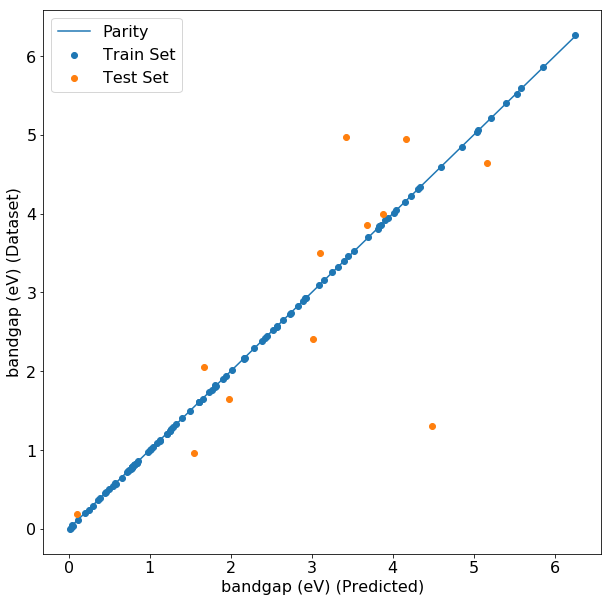

In [14]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_halidesOnly.csv
Rows: 119
Target: exfoliation_energy_per_atom (eV/atom)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.45632015796171416

Generation 2 - Current best internal CV score: 0.46935474810640065

Generation 3 - Current best internal CV score: 0.4969010267451994

Generation 4 - Current best internal CV score: 0.4969010267451994

Generation 5 - Current best internal CV score: 0.5065234552050824

5.47 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: GradientBoostingRegressor(OneHotEncoder(input_matrix, minimum_fraction=0.15, sparse=False, threshold=10), alpha=0.85, learning_rate=0.1, loss=huber, max_depth=6, max_features=0.9000000000000001, min_samples_leaf=14, min_samples_split=5, n_estimators=100, subsample=0.8)
Imputing missing values in feature set
Imputing missing values in feature set
Test-Set Error Metrics:
MAE: 0.018
MAPE: 0.253
MSE: 0.001
R2: 0.442
Max Error: 0.068


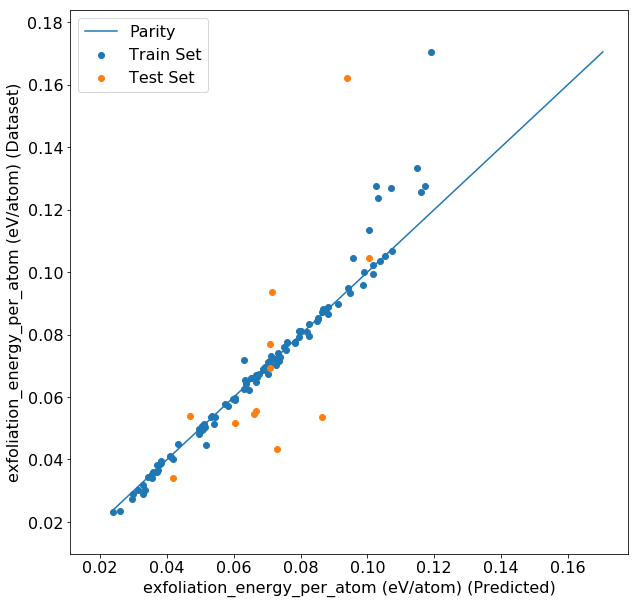

In [15]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_nitridesOnly.csv
Rows: 13
Target: bandgap (eV)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.45883618447672414

Generation 2 - Current best internal CV score: -0.45883618447672414

Generation 3 - Current best internal CV score: -0.4358159574570177

Generation 4 - Current best internal CV score: -0.4358159574570177

Generation 5 - Current best internal CV score: -0.35422483535165294

Generation 6 - Current best internal CV score: -0.35422483535165294

Generation 7 - Current best internal CV score: -0.35422483535165294

Generation 8 - Current best internal CV score: -0.35422483535165294

Generation 9 - Current best internal CV score: -0.35422483535165294

Generation 10 - Current best internal CV score: -0.35422483535165294

Generation 11 - Current best internal CV score: -0.3276574329511719

Generation 12 - Current best internal CV score: -0.3276574329511719

Generation 13 - Current best internal CV score: -0.3276574329511719

Generation 14 - Current best internal CV score: -0.3276574329511719

Generation 15 - Current best inter

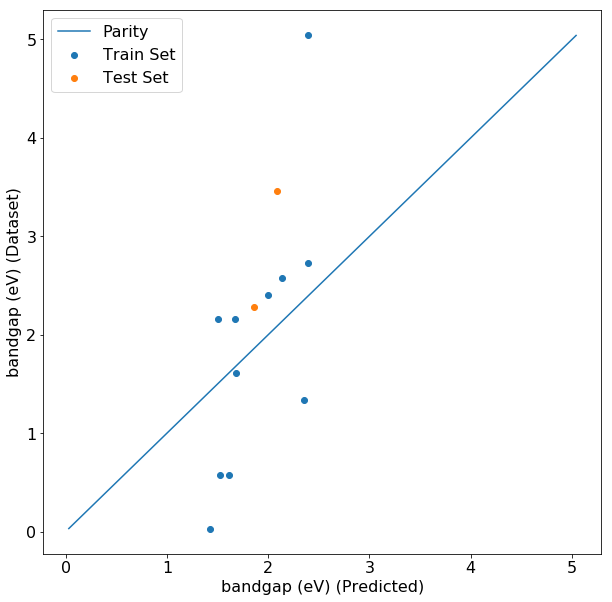

In [16]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_nitridesOnly.csv
Rows: 13
Target: exfoliation_energy_per_atom (eV/atom)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -2.16987496421642

Generation 2 - Current best internal CV score: -2.080880234619473

Generation 3 - Current best internal CV score: -2.045187230303006

Generation 4 - Current best internal CV score: -1.1165764315056117

Generation 5 - Current best internal CV score: -1.1165764315056117

Generation 6 - Current best internal CV score: -1.1165764315056117

Generation 7 - Current best internal CV score: -1.1165764315056117

Generation 8 - Current best internal CV score: -1.1165764315056117

Generation 9 - Current best internal CV score: -1.1165764315056117

Generation 10 - Current best internal CV score: -1.006700083241611

5.18 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: AdaBoostRegressor(VarianceThreshold(Normalizer(input_matrix, norm=l2), threshold=0.0001), learning_rate=1.0, loss=exponential, n_estimators=100)
I

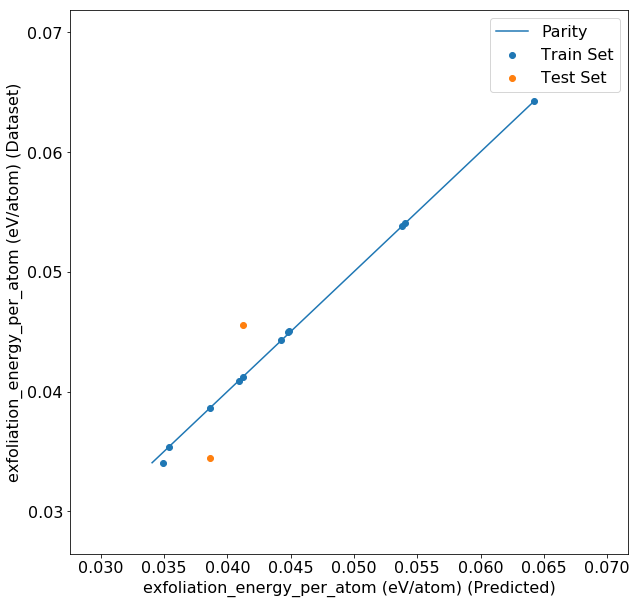

In [17]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_oxidesOnly.csv
Rows: 64
Target: bandgap (eV)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.37635974178807063

Generation 2 - Current best internal CV score: 0.4185762196188568

Generation 3 - Current best internal CV score: 0.4415936091199396

Generation 4 - Current best internal CV score: 0.4415936091199396

Generation 5 - Current best internal CV score: 0.45935544167894454

Generation 6 - Current best internal CV score: 0.45935544167894454

5.70 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: AdaBoostRegressor(ElasticNetCV(input_matrix, l1_ratio=0.7000000000000001, tol=0.01), learning_rate=0.1, loss=exponential, n_estimators=100)
Imputing missing values in feature set
Imputing missing values in feature set
Test-Set Error Metrics:
MAE: 0.734
MAPE: 0.197
MSE: 0.791
R2: 0.388
Max Error: 1.634


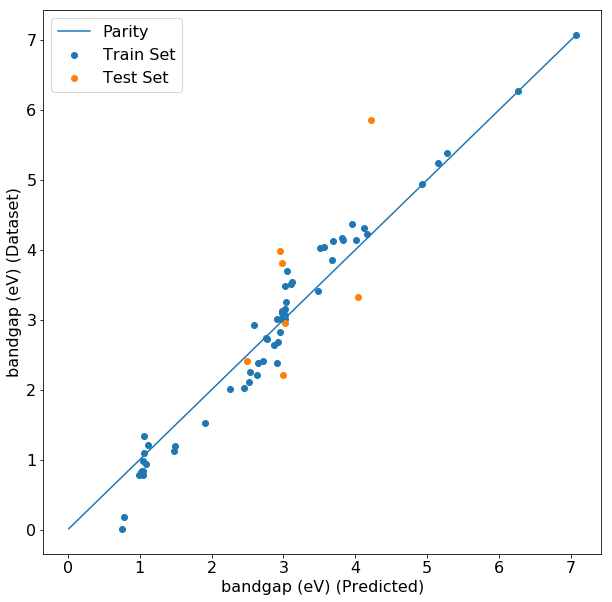

In [18]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_oxidesOnly.csv
Rows: 64
Target: exfoliation_energy_per_atom (eV/atom)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.17245663104036935

Generation 2 - Current best internal CV score: 0.20065864049324705

Generation 3 - Current best internal CV score: 0.20065864049324705

Generation 4 - Current best internal CV score: 0.20065864049324705

Generation 5 - Current best internal CV score: 0.22401685145222183

Generation 6 - Current best internal CV score: 0.22401685145222183

5.01 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: RandomForestRegressor(RandomForestRegressor(SelectPercentile(input_matrix, percentile=72), bootstrap=True, max_features=0.15000000000000002, min_samples_leaf=7, min_samples_split=16, n_estimators=100), bootstrap=True, max_features=0.9000000000000001, min_samples_leaf=4, min_samples_split=14, n_estimators=100)
Imputing missing values in feature set
Imputing missing values in feature set
Test-Set Error Metrics:
M

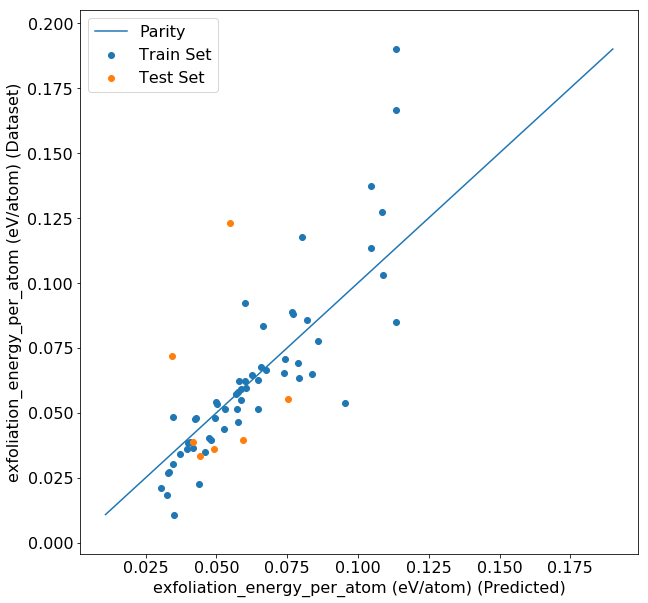

In [19]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_pBlockMetalsOnly.csv
Rows: 87
Target: bandgap (eV)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.5950382729435895

Generation 2 - Current best internal CV score: 0.6023082157484587

Generation 3 - Current best internal CV score: 0.6231813785430419

Generation 4 - Current best internal CV score: 0.6231813785430419

Generation 5 - Current best internal CV score: 0.6311789821519531

Generation 6 - Current best internal CV score: 0.6311789821519531

5.72 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ElasticNetCV(PCA(MinMaxScaler(input_matrix), iterated_power=6, svd_solver=randomized), l1_ratio=0.25, tol=0.01)
Imputing missing values in feature set
Imputing missing values in feature set
Test-Set Error Metrics:
MAE: 0.852
MAPE: 0.459
MSE: 2.074
R2: -1.737
Max Error: 3.977


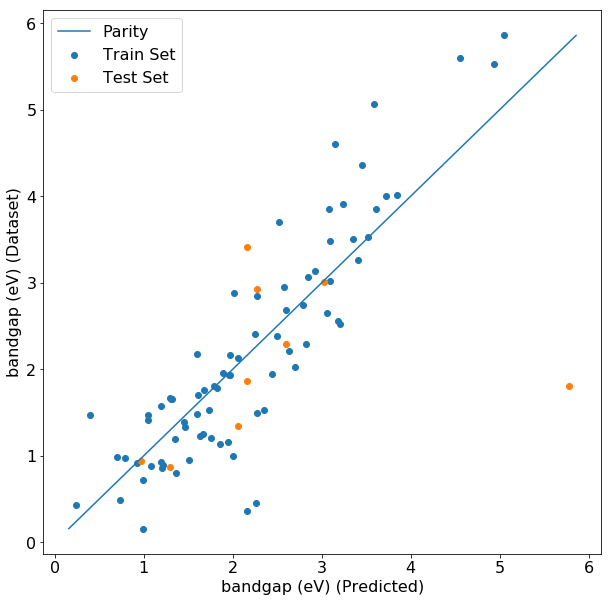

In [20]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_pBlockMetalsOnly.csv
Rows: 87
Target: exfoliation_energy_per_atom (eV/atom)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.3063997847188038

Generation 2 - Current best internal CV score: 0.3063997847188038

Generation 3 - Current best internal CV score: 0.3391165625200776

Generation 4 - Current best internal CV score: 0.3541518226592756

Generation 5 - Current best internal CV score: 0.35730021042677385

Generation 6 - Current best internal CV score: 0.3594457652037337

Generation 7 - Current best internal CV score: 0.3594457652037337

5.48 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: LassoLarsCV(GradientBoostingRegressor(input_matrix, alpha=0.75, learning_rate=0.01, loss=ls, max_depth=8, max_features=0.8, min_samples_leaf=10, min_samples_split=7, n_estimators=100, subsample=0.6500000000000001), normalize=True)
Imputing missing values in feature set
Imputing missing values in feature set
Test-Set Error Metrics:
MAE: 0.027
MAPE: 0.

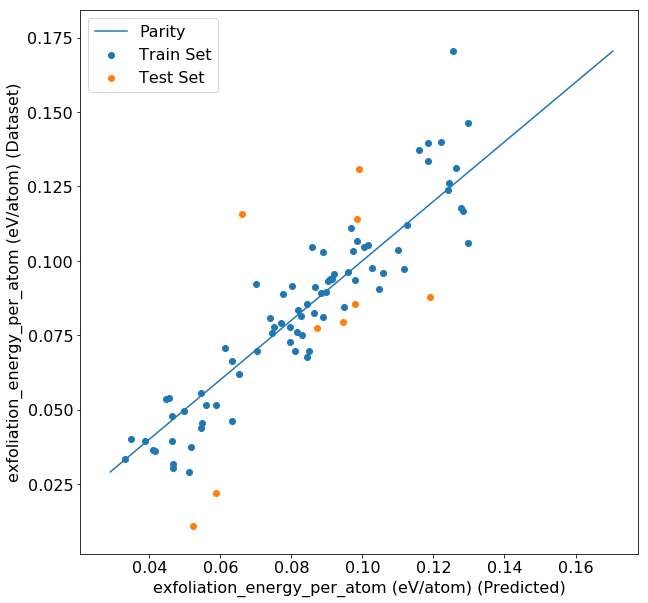

In [21]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_pnictogensOnly.csv
Rows: 92
Target: bandgap (eV)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.5111585192470687

Generation 2 - Current best internal CV score: 0.5111585192470687

Generation 3 - Current best internal CV score: 0.5111585192470687

Generation 4 - Current best internal CV score: 0.5171023702833785

Generation 5 - Current best internal CV score: 0.5171023702833785

5.12 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ElasticNetCV(MinMaxScaler(input_matrix), l1_ratio=0.30000000000000004, tol=0.01)
Imputing missing values in feature set
Imputing missing values in feature set
Test-Set Error Metrics:
MAE: 0.581
MAPE: 0.297
MSE: 0.522
R2: 0.332
Max Error: 1.22


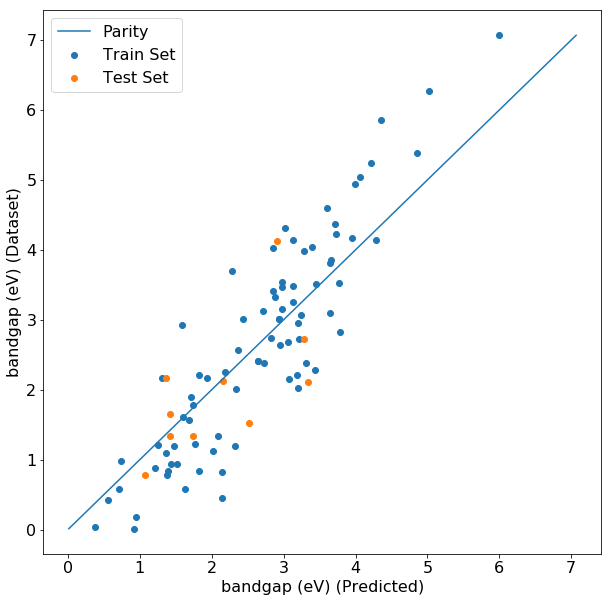

In [22]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_pnictogensOnly.csv
Rows: 92
Target: exfoliation_energy_per_atom (eV/atom)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.17833379273257033

Generation 2 - Current best internal CV score: 0.20801074768013114

Generation 3 - Current best internal CV score: 0.20801074768013114

Generation 4 - Current best internal CV score: 0.3118155362641597

Generation 5 - Current best internal CV score: 0.3118155362641597

Generation 6 - Current best internal CV score: 0.3118155362641597

Generation 7 - Current best internal CV score: 0.3118155362641597

Generation 8 - Current best internal CV score: 0.3213066935071144

5.17 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesRegressor(Binarizer(input_matrix, threshold=0.8), bootstrap=False, max_features=1.0, min_samples_leaf=9, min_samples_split=5, n_estimators=100)
Imputing missing values in feature set
Imputing missing values in feature set
Test-Set Error Metrics:
MAE: 0.02
MAPE: 0.294
MSE: 

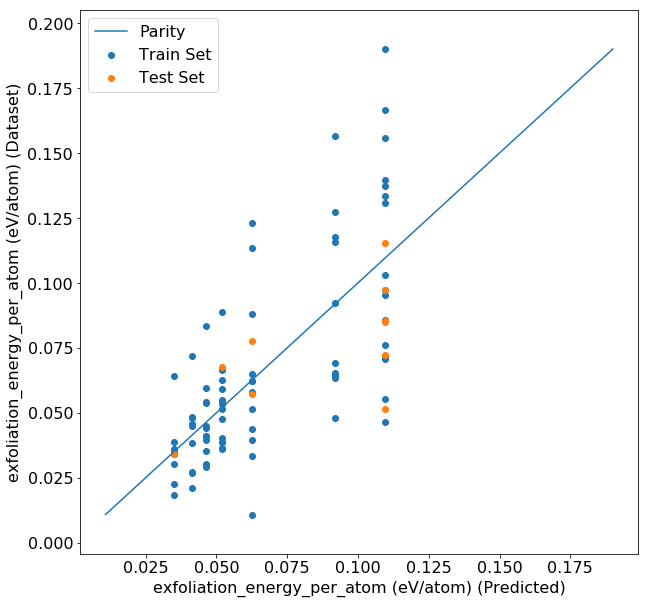

In [23]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_sulfidesOnly.csv
Rows: 48
Target: bandgap (eV)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.3329825652204416

Generation 2 - Current best internal CV score: 0.3329825652204416

Generation 3 - Current best internal CV score: 0.47116603096779147

Generation 4 - Current best internal CV score: 0.47116603096779147

Generation 5 - Current best internal CV score: 0.47116603096779147

Generation 6 - Current best internal CV score: 0.47116603096779147

Generation 7 - Current best internal CV score: 0.47116603096779147

Generation 8 - Current best internal CV score: 0.47116603096779147

5.26 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: RidgeCV(Binarizer(input_matrix, threshold=0.9500000000000001))
Imputing missing values in feature set
Imputing missing values in feature set
Test-Set Error Metrics:
MAE: 0.412
MAPE: 0.173
MSE: 0.329
R2: 0.91
Max Error: 1.051


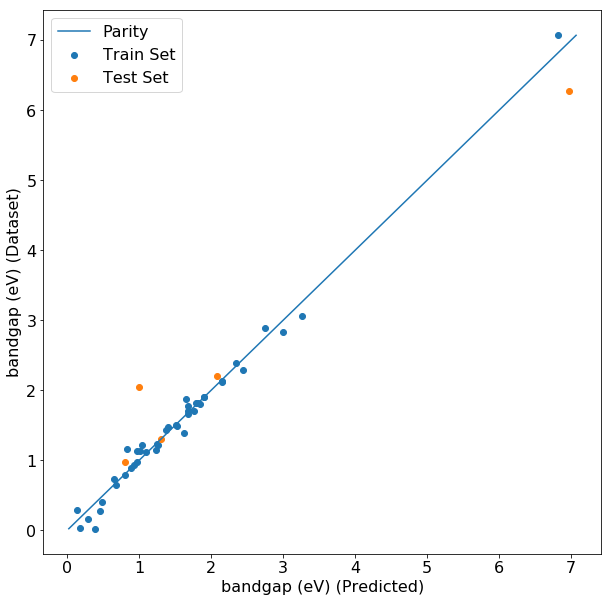

In [24]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_sulfidesOnly.csv
Rows: 48
Target: exfoliation_energy_per_atom (eV/atom)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.16327281067106744

Generation 2 - Current best internal CV score: 0.16327281067106744

Generation 3 - Current best internal CV score: 0.16327281067106744

Generation 4 - Current best internal CV score: 0.16327281067106744

Generation 5 - Current best internal CV score: 0.24533153959832346

Generation 6 - Current best internal CV score: 0.24533153959832346

Generation 7 - Current best internal CV score: 0.24533153959832346

5.06 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesRegressor(DecisionTreeRegressor(SGDRegressor(input_matrix, alpha=0.01, eta0=1.0, fit_intercept=True, l1_ratio=0.25, learning_rate=invscaling, loss=epsilon_insensitive, penalty=elasticnet, power_t=10.0), max_depth=1, min_samples_leaf=3, min_samples_split=2), bootstrap=False, max_features=0.35000000000000003, min_samples_leaf=2, min_sam

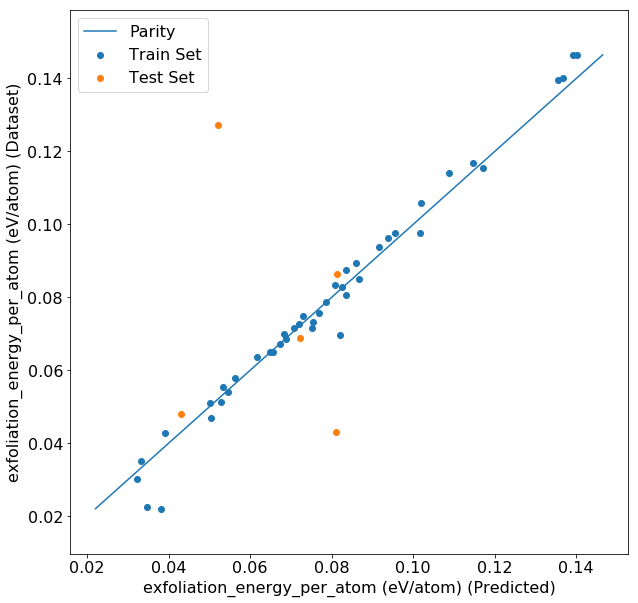

In [25]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_UWBGOnly.csv
Rows: 50
Target: bandgap (eV)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.47851209959030394

Generation 2 - Current best internal CV score: 0.4820294459643042

Generation 3 - Current best internal CV score: 0.4820294459643042

Generation 4 - Current best internal CV score: 0.49278530480778276

Generation 5 - Current best internal CV score: 0.49278530480778276

Generation 6 - Current best internal CV score: 0.5129150491960558

Generation 7 - Current best internal CV score: 0.5129150491960558

Generation 8 - Current best internal CV score: 0.5162208728477793

5.41 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: LassoLarsCV(RandomForestRegressor(SelectFwe(Binarizer(input_matrix, threshold=0.25), alpha=0.026000000000000002), bootstrap=False, max_features=0.45, min_samples_leaf=8, min_samples_split=8, n_estimators=100), normalize=False)
Imputing missing values in feature set
Imputing missing 

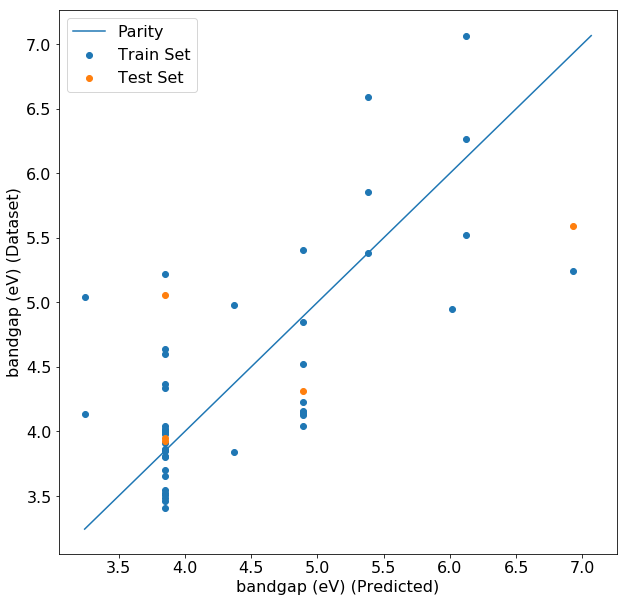

In [26]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

In [ ]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_UWBGOnly.csv
Rows: 50
Target: exfoliation_energy_per_atom (eV/atom)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]

In [ ]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

In [ ]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

In [ ]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)